In [1]:
# Import libraries
#import glob
import pydicom
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import Slider
import time
import os
import re
import ipywidgets as ipyw
from scipy import ndimage
from PIL import Image, ImageOps
from zipfile import ZipFile
#import ipyvolume as ipv
import itertools
from scipy.ndimage import zoom
import SimpleITK as sitk
import scipy.ndimage
from scipy.ndimage import rotate
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#from plotly.tools import FigureFactory as FF
#from plotly.graph_objs import *
#init_notebook_mode(connected=True) 
import pandas as pd
from IPython.display import Image 
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

# Kaplan-Meier curve
from string import ascii_lowercase# Visualisation
import seaborn as sns
#sns.set(style='dark', context='talk')# Kaplan-Meier curve
from lifelines import KaplanMeierFitter 
from sksurv.nonparametric import kaplan_meier_estimator

import missingno
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter, WeibullAFTFitter , LogNormalAFTFitter, LogLogisticAFTFitter , PiecewiseExponentialRegressionFitter
from lifelines.utils import k_fold_cross_validation
from IPython.display import HTML

from radiomics import featureextractor 
import nrrd
import traceback
import datetime
import warnings
warnings.filterwarnings("ignore")
import csv

import pandas as pd # for reading and writing tables
import skimage # for image processing and visualizations
import sklearn # for machine learning and statistical models
from pathlib import Path # help manage files
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [2]:
## Special functions for using pyradiomics
from SimpleITK import GetImageFromArray
from radiomics.featureextractor import RadiomicsFeatureExtractor
import logging
logging.getLogger('radimics').setLevel(logging.CRITICAL +1)

In [3]:
# Instantiate the extractor
texture_extractor = RadiomicsFeatureExtractor(verbose=False)
texture_extractor.disableAllFeatures()
_text_feat = {ckey: [] for ckey in texture_extractor.featureClassNames}
texture_extractor.enableFeaturesByName(**_text_feat)

print('Extraction parameters:\n\t', texture_extractor.settings)
print('Enabled filters:\n\t', texture_extractor.enabledImagetypes) 
print('Enabled features:\n\t', texture_extractor.enabledFeatures) 

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'verbose': False}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

In [5]:
import h5py # for reading the image files
root_path = Path("./data_n_400/storage/")
root_ = "./data_n_400/"

In [6]:
# CT volume
all_df = pd.DataFrame({'h5_path': list(root_path.glob('*/*.h5'))})
print(all_df)
all_df['file_id'] = all_df['h5_path'].map(lambda x: x.stem)
all_df['training_group'] = all_df['h5_path'].map(lambda x: x.parent.stem)
all_df['scan_id'] = all_df['file_id']#.map(lambda x: int(x.split('_')[-1]))
all_df.head(5) # show the first 5 lines

                                 h5_path
0    data_n_400/storage/train/LC01119.h5
1    data_n_400/storage/train/LC06187.h5
2    data_n_400/storage/train/LC02473.h5
3    data_n_400/storage/train/LC01475.h5
4    data_n_400/storage/train/LC09857.h5
..                                   ...
224   data_n_400/storage/test/LC09948.h5
225   data_n_400/storage/test/LC09932.h5
226   data_n_400/storage/test/LC10084.h5
227   data_n_400/storage/test/LC10059.h5
228   data_n_400/storage/test/LC23886.h5

[229 rows x 1 columns]


,h5_path,file_id,training_group,scan_id
0,data_n_400/storage/train/LC01119.h5,LC01119,train,LC01119
1,data_n_400/storage/train/LC06187.h5,LC06187,train,LC06187
2,data_n_400/storage/train/LC02473.h5,LC02473,train,LC02473
3,data_n_400/storage/train/LC01475.h5,LC01475,train,LC01475
4,data_n_400/storage/train/LC09857.h5,LC09857,train,LC09857


In [7]:
# Read image
def read_scan(full_scan_path):
    # load the image using hdf5
    with h5py.File(full_scan_path, 'r') as h:
        # [::2, ::4, ::4, 0] downsampling makes it go much faster
        return h['image'][:][:, :, :] # we read the data from the file

In [8]:
# load image
sample_scan = all_df.iloc[0] # just take the first row
print(sample_scan)
# turn the h5_path into the full path
image_data = read_scan(sample_scan['h5_path'])
print('Image Shape:', image_data.shape)

h5_path           data_n_400/storage/train/LC01119.h5
file_id                                       LC01119
training_group                                  train
scan_id                                       LC01119
Name: 0, dtype: object
Image Shape: (112, 77, 77)


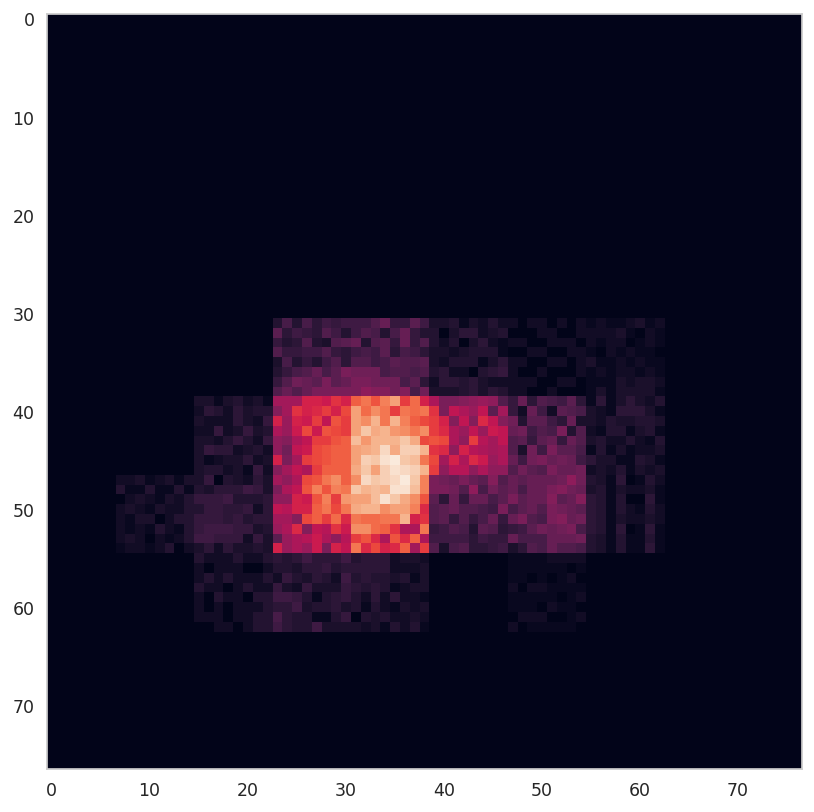

In [9]:
plt.imshow(np.sum((image_data>0).astype(float), 0))

In [10]:
%%time
results = texture_extractor.execute(GetImageFromArray(image_data),
                            GetImageFromArray((image_data>0).astype(np.uint8)))


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


CPU times: user 1.32 s, sys: 333 ms, total: 1.66 s
Wall time: 1.49 s


In [11]:
pd.DataFrame([results]).T

,0
diagnostics_Versions_PyRadiomics,v3.0.1
diagnostics_Versions_Numpy,1.22.3
diagnostics_Versions_SimpleITK,2.1.1
diagnostics_Versions_PyWavelet,1.1.1
diagnostics_Versions_Python,3.8.11
...,...
original_ngtdm_Busyness,2.2019079393388568
original_ngtdm_Coarseness,2.513122410547939e-06
original_ngtdm_Complexity,50380481.395629056
original_ngtdm_Contrast,192577.84565724293


In [12]:
import tabulate

In [13]:
display([results])

[OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
              ('diagnostics_Versions_Numpy', '1.22.3'),
              ('diagnostics_Versions_SimpleITK', '2.1.1'),
              ('diagnostics_Versions_PyWavelet', '1.1.1'),
              ('diagnostics_Versions_Python', '3.8.11'),
              ('diagnostics_Configuration_Settings',
               {'minimumROIDimensions': 2,
                'minimumROISize': None,
                'normalize': False,
                'normalizeScale': 1,
                'removeOutliers': None,
                'resampledPixelSpacing': None,
                'interpolator': 'sitkBSpline',
                'preCrop': False,
                'padDistance': 5,
                'distances': [1],
                'force2D': False,
                'force2Ddimension': 0,
                'resegmentRange': None,
                'label': 1,
                'additionalInfo': True,
                'verbose': False}),
              ('diagnostics_Configuration_Ena

In [14]:
def calc_radiomics(in_image_data):
    return texture_extractor.execute(GetImageFromArray(in_image_data),
                            GetImageFromArray((in_image_data>0).astype(np.uint8)))


In [15]:
%%time
all_df['radiomics'] = all_df['h5_path'].map(lambda c_filename: calc_radiomics(read_scan(c_filename)))

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

CPU times: user 3min 39s, sys: 59.3 s, total: 4min 39s
Wall time: 4min 7s


In [16]:
full_df = pd.DataFrame([dict(**c_row.pop('radiomics'), **c_row) for _, c_row in all_df.iterrows()])
print(full_df.shape, 'data prepared')
first_cols = all_df.columns[:-1].tolist()
full_df = full_df[first_cols + [c_col for c_col in full_df.columns 
                                if c_col not in first_cols]]
# export the whole table
full_df.to_csv('all_radiomics_table.csv', index=False)
full_df.sample(3)

(229, 133) data prepared


,h5_path,file_id,training_group,scan_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
2,data_n_400/storage/train/LC02473.h5,LC02473,train,LC02473,v3.0.1,1.22.3,2.1.1,1.1.1,3.8.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,1801909.9798194326,0.027770464096894272,6.694247088631587,0.4329693187727509,2088.200788791182,1.3600568656357488,3.8747145421310216e-06,42234850.27000016,174416.10157776755,143.98502394913837
43,data_n_400/storage/train/LC02963.h5,LC02963,train,LC02963,v3.0.1,1.22.3,2.1.1,1.1.1,3.8.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,751153.5039583646,0.042928005154494554,6.363856210433305,0.5101032779524023,65.64367731476891,0.5292977185525505,2.3112362005771495e-05,33479736.846897498,232786.16866098566,491.90296737991645
157,data_n_400/storage/train/LC09914.h5,LC09914,train,LC09914,v3.0.1,1.22.3,2.1.1,1.1.1,3.8.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,1349144.2835494375,0.04750219945630287,6.421360974847707,0.47433264887063653,677.003294540957,1.2918045522280068,5.179817459578301e-06,43119460.5459938,195801.29952342057,180.13251980616934


In [17]:
# Focusing on Interesting Radiomics
# leave out anything that doesn't start with original (just junk from the input)
# also remove shape since it is not very informative
value_feature_names = [c_col for c_col in full_df.columns if (c_col.startswith('original') and '_shape_' not in c_col)]
print(np.random.choice(value_feature_names, 3), 'of', len(value_feature_names))

['original_glszm_SizeZoneNonUniformity' 'original_firstorder_TotalEnergy'
 'original_glcm_JointAverage'] of 93


In [18]:
# make a cleaner vefirst_colson
clean_df = full_df[first_cols + value_feature_names].copy()
clean_df.columns = first_cols + [
    ' '.join(c_col.split('original_')[-1].split('_')) 
    for c_col in value_feature_names
]
clean_col_names = clean_df.columns[len(first_cols):]
# fix some of the artifacts from the radiomics tool
obj_cols = clean_df[clean_col_names].select_dtypes(['object']).columns.tolist()
for c_col in obj_cols:
    clean_df[c_col] = clean_df[c_col].map(lambda x: float(x))
clean_df.to_csv('clean_radiomics_table.csv', index=False)
clean_df.sample(10)


,h5_path,file_id,training_group,scan_id,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,...,glszm SmallAreaHighGrayLevelEmphasis,glszm SmallAreaLowGrayLevelEmphasis,glszm ZoneEntropy,glszm ZonePercentage,glszm ZoneVariance,ngtdm Busyness,ngtdm Coarseness,ngtdm Complexity,ngtdm Contrast,ngtdm Strength
202,data_n_400/storage/test/LC09935.h5,LC09935,test,LC09935,768.0,65280.0,4.210092e+12,4.551883,63488.0,1.018208,...,1.584306e+06,0.041716,6.566546,0.445248,282.939514,0.437473,1.831522e-05,3.410229e+07,341712.845266,509.044591
26,data_n_400/storage/train/LC01469.h5,LC01469,train,LC01469,614.4,65280.0,1.089328e+13,4.674235,63232.0,1.056168,...,1.444144e+06,0.039658,6.320233,0.542252,98.877962,1.291256,6.143139e-06,4.757316e+07,289229.386283,163.575418
105,data_n_400/storage/train/LC09854.h5,LC09854,train,LC09854,768.0,65280.0,2.249310e+13,4.444169,63488.0,1.076743,...,1.794480e+06,0.035379,6.592973,0.443911,2051.122084,1.397140,3.970562e-06,3.887115e+07,176339.766005,149.694430
133,data_n_400/storage/train/LC06389.h5,LC06389,train,LC06389,768.0,65280.0,5.321496e+12,4.542827,63488.0,1.024402,...,1.312743e+06,0.033481,6.470468,0.440350,374.822211,0.462266,1.806008e-05,2.785015e+07,234560.873671,493.833215
71,data_n_400/storage/train/LC06312.h5,LC06312,train,LC06312,512.0,65280.0,7.795658e+11,4.527903,63488.0,1.009266,...,1.556736e+06,0.039589,5.609640,0.585366,37.752894,0.106848,9.711322e-05,2.991324e+07,646710.086055,1812.914771
27,data_n_400/storage/train/LC04872.h5,LC04872,train,LC04872,768.0,65280.0,9.618896e+12,4.367390,63488.0,1.016381,...,1.283049e+06,0.037079,6.536121,0.431324,1061.264857,0.603405,9.944986e-06,3.394484e+07,163476.517155,362.086022
103,data_n_400/storage/train/LC01521.h5,LC01521,train,LC01521,768.0,65280.0,7.583962e+13,4.585370,63744.0,1.014290,...,1.521182e+06,0.041120,6.395353,0.518183,1466.188560,7.146728,8.218177e-07,6.019976e+07,202504.843075,29.872986
121,data_n_400/storage/train/LC06338.h5,LC06338,train,LC06338,512.0,65280.0,7.618274e+11,4.444904,64000.0,1.041135,...,1.552913e+06,0.031961,5.905867,0.538462,47.108624,0.130898,8.560925e-05,2.890460e+07,559188.049041,1858.130902
54,data_n_400/storage/train/LC03959.h5,LC03959,train,LC03959,512.0,65280.0,2.602322e+12,4.701910,62976.0,1.136289,...,1.355282e+06,0.049582,6.172293,0.574232,55.947962,0.399829,2.546539e-05,3.837889e+07,354624.460188,579.545300
84,data_n_400/storage/train/LC05307.h5,LC05307,train,LC05307,768.0,65280.0,2.424718e+13,4.588705,63744.0,1.023567,...,1.382948e+06,0.037437,6.540566,0.484459,1223.084577,1.998932,3.151355e-06,4.616914e+07,177375.467801,108.636927


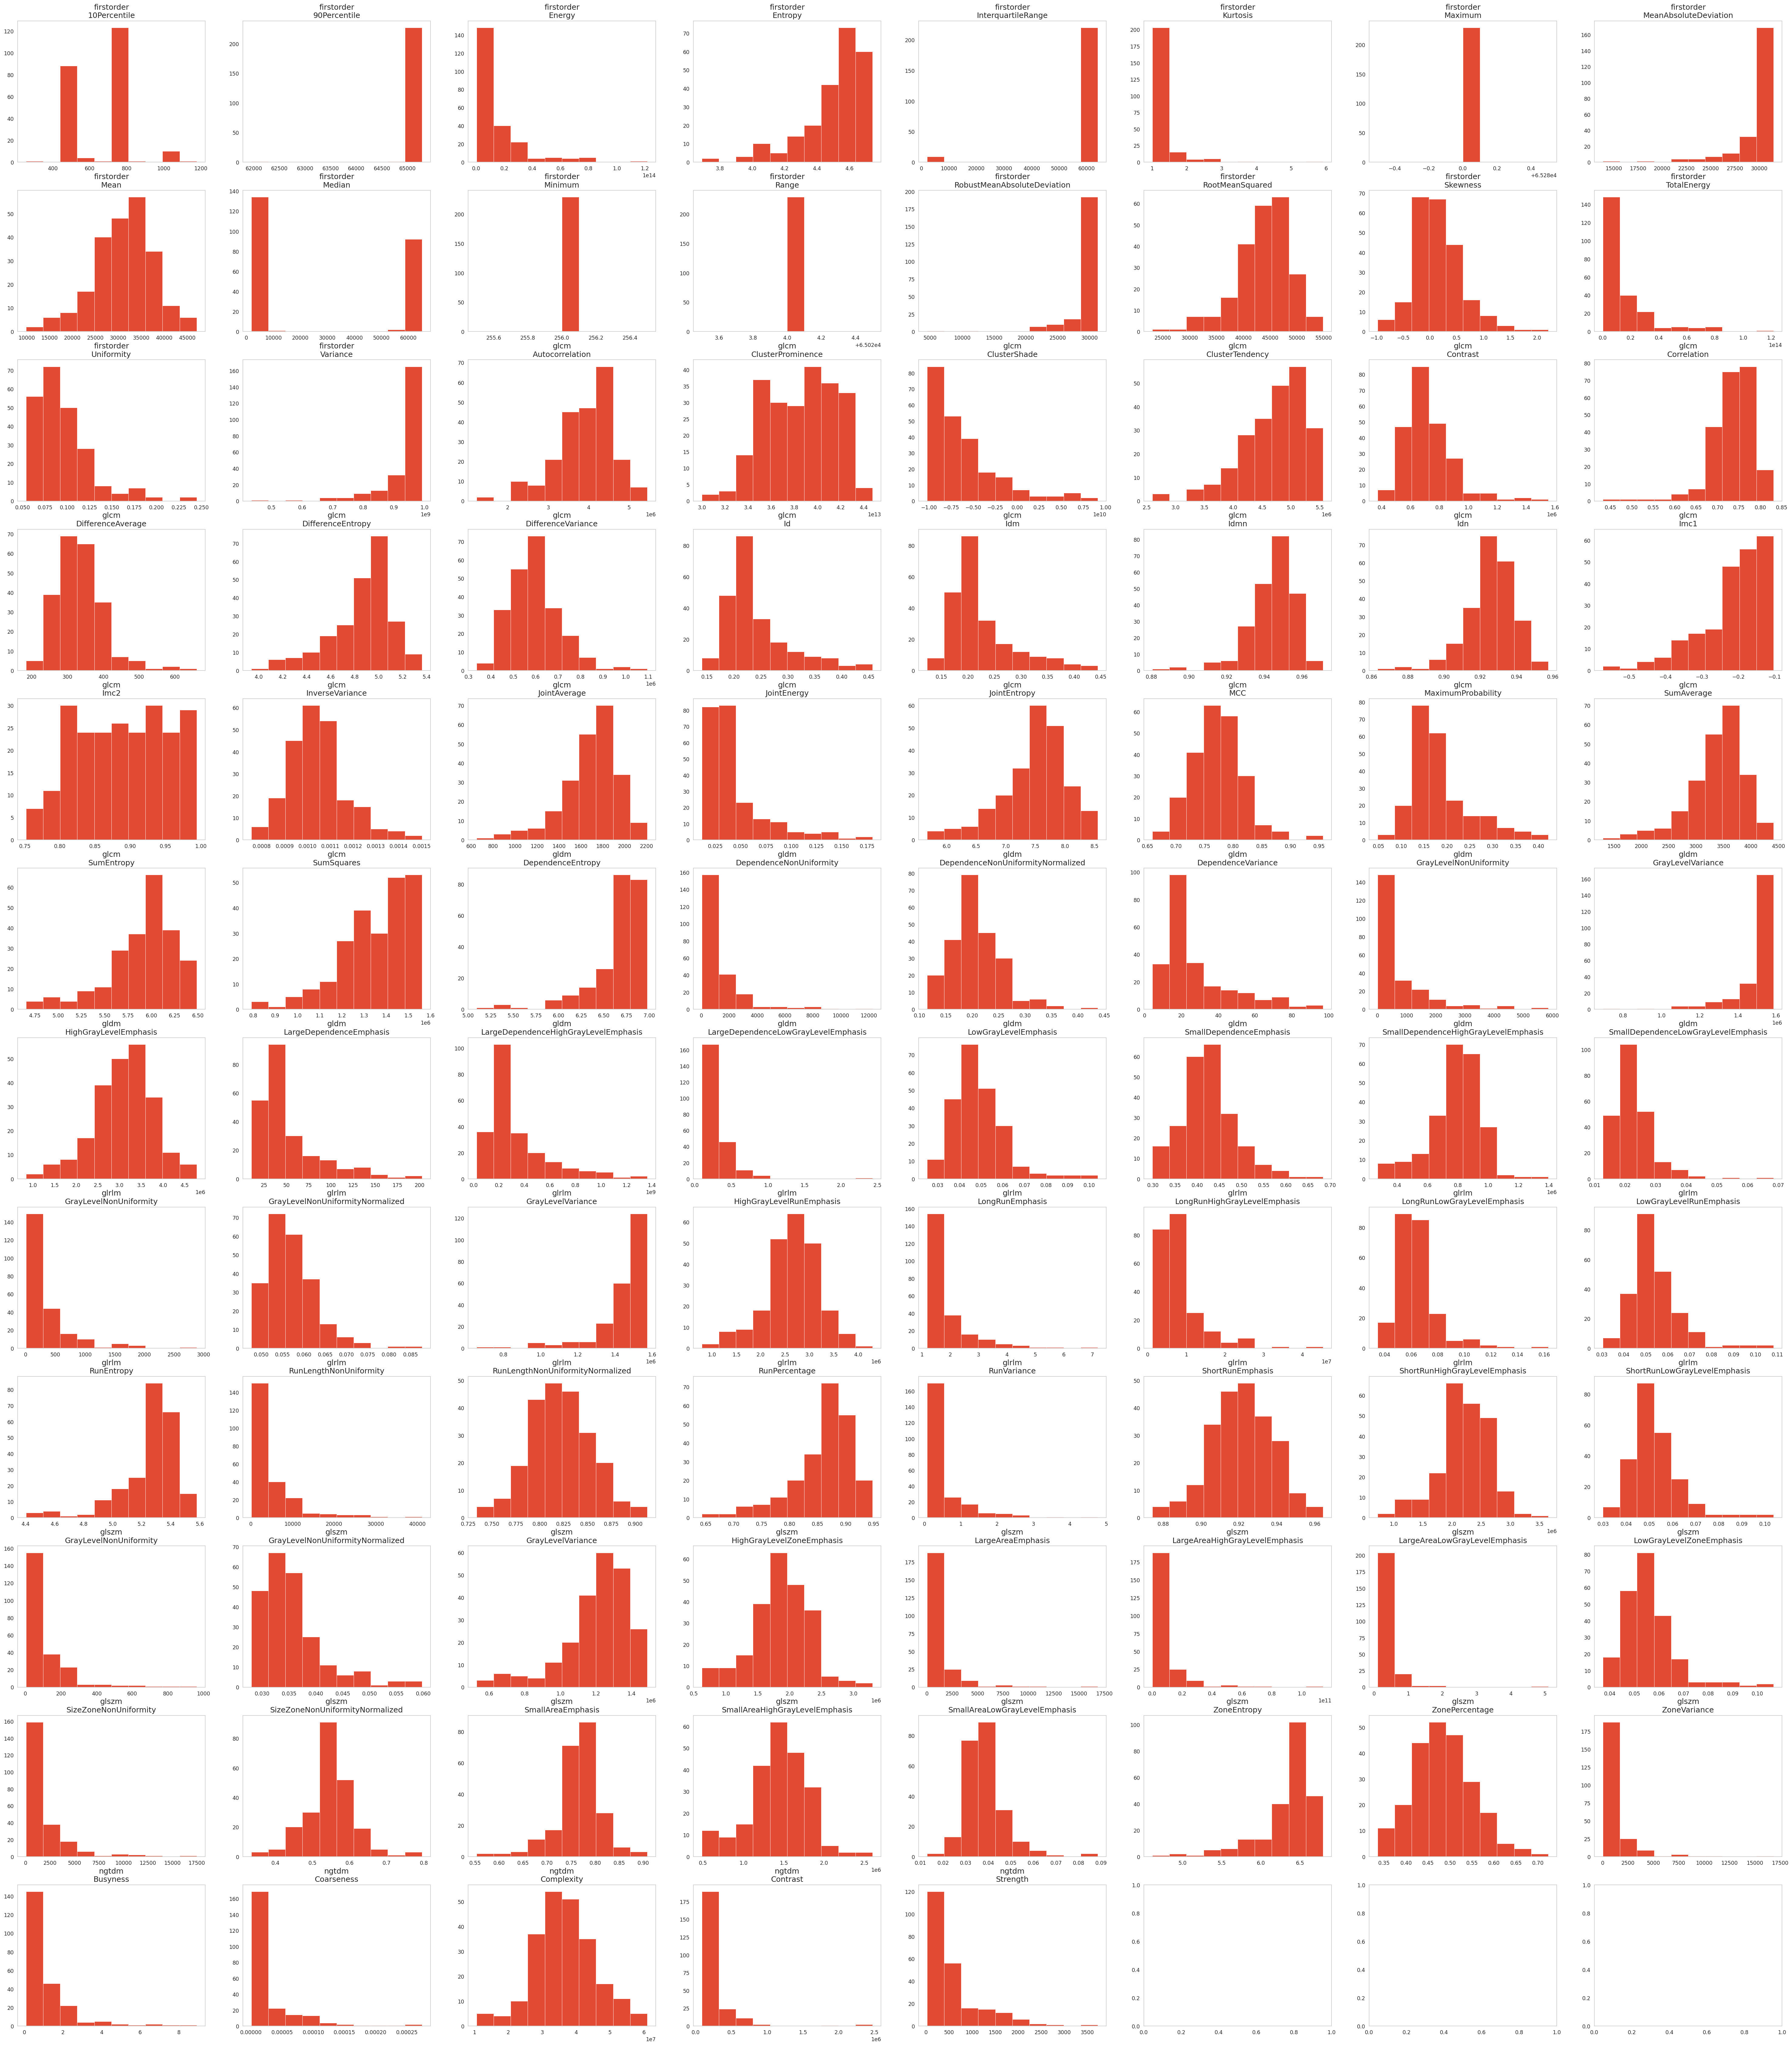

In [19]:
# Show the distribution of different variables
fig, m_axs = plt.subplots(12, 8, figsize=(60, 70))
for c_ax, c_var in zip(m_axs.flatten(), clean_col_names):
    c_ax.hist(clean_df[c_var].values, bins=10)
    c_ax.set_title('\n'.join(c_var.split(' ')))
fig.savefig('all_metrics.png')

In [20]:
clean_df.to_hdf('clean_radiomics_table.h5', 'data', mode='w')

In [21]:
statistics_ = root_ + "AIDATA_NSCLC+SCLC_20201130_tissue(n246)_20210202.xlsx" ## For training
df_clinical_ = pd.read_excel(open(statistics_, 'rb'), sheet_name='Sheet1')  

In [22]:
df_clinical_

,PatientID,gender,age,histology,Overall.stage,Clinical.T.stage,Clinical.N.stage,Clinical.M.stage,Smoking.status,Smoking.amount,Deadstatus.event,Survival.time
0,LC00026,male,58.008219,squamous cell carcinoma,3A,3,1,0,1,3.0,1,34
1,LC00028,male,73.145205,squamous cell carcinoma,3A,1b,2,0,1,25.0,1,74
2,LC00202,male,64.520548,squamous cell carcinoma,4,2a,2,1a,0,0.0,1,195
3,LC00276,male,58.643836,squamous cell carcinoma,3B,2a,3,0,1,40.0,1,829
4,LC00294,female,77.131507,adenocarcinoma,4,1b,3,1b,0,0.0,1,170
...,...,...,...,...,...,...,...,...,...,...,...,...
241,LC10087,male,79.701370,SCLC,ED,.,.,.,1,40.0,1,134
242,LC10093,female,48.791781,adenocarcinoma,4,4,2,1a,0,0.0,9,585
243,LC21394,male,78.049315,squamous cell carcinoma,4,2b,2,1b,1,30.0,9,114
244,LC22147,male,73.284932,SCLC,LD,.,.,.,1,50.0,1,27


In [23]:
df_INNER_JOIN = pd.merge(clean_df, df_clinical_, left_on='file_id', right_on='PatientID', how='inner')

In [24]:
df_INNER_JOIN

,h5_path,file_id,training_group,scan_id,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,...,age,histology,Overall.stage,Clinical.T.stage,Clinical.N.stage,Clinical.M.stage,Smoking.status,Smoking.amount,Deadstatus.event,Survival.time
0,data_n_400/storage/train/LC01119.h5,LC01119,train,LC01119,768.0,65280.0,2.855820e+13,4.427072,63488.0,1.018516,...,60.186301,adenocarcinoma,4,4,3,1a,0,0.0,1,71
1,data_n_400/storage/train/LC06187.h5,LC06187,train,LC06187,512.0,65280.0,6.850649e+12,4.702467,62720.0,1.382140,...,75.020000,squamous cell carcinoma,2B,3,0,0,1,40.0,9,569
2,data_n_400/storage/train/LC02473.h5,LC02473,train,LC02473,768.0,65280.0,2.313576e+13,4.489302,63232.0,1.113902,...,56.271233,SCLC,LD,.,.,.,1,30.0,9,8
3,data_n_400/storage/train/LC01475.h5,LC01475,train,LC01475,768.0,65280.0,3.055276e+13,4.422490,63744.0,1.012187,...,72.745205,SCLC,LD,.,.,.,1,45.0,1,28
4,data_n_400/storage/train/LC09857.h5,LC09857,train,LC09857,1024.0,65280.0,3.965642e+13,3.742879,61440.0,1.972023,...,46.484932,squamous cell carcinoma,3A,4,1,0,1,60.0,1,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,data_n_400/storage/test/LC09948.h5,LC09948,test,LC09948,768.0,65280.0,2.425002e+13,4.155293,62976.0,1.238474,...,65.369863,squamous cell carcinoma,4,2b,3,1a,1,60.0,1,212
225,data_n_400/storage/test/LC09932.h5,LC09932,test,LC09932,1024.0,65280.0,2.172468e+13,4.062609,62976.0,1.267356,...,61.876712,large cell,4,3,0,1b,1,40.0,0,1249
226,data_n_400/storage/test/LC10084.h5,LC10084,test,LC10084,512.0,65280.0,1.713767e+12,4.733948,61952.0,1.678809,...,58.794521,adenocarcinoma,1B,2a,0,0,0,0.0,0,1050
227,data_n_400/storage/test/LC10059.h5,LC10059,test,LC10059,768.0,65280.0,5.219136e+12,4.565769,63744.0,1.008026,...,76.194521,squamous cell carcinoma,1B,2a,0,0,1,120.0,1,801


In [25]:
df_train = df_INNER_JOIN[df_INNER_JOIN['training_group'] == "train"]
df_train 

,h5_path,file_id,training_group,scan_id,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,...,age,histology,Overall.stage,Clinical.T.stage,Clinical.N.stage,Clinical.M.stage,Smoking.status,Smoking.amount,Deadstatus.event,Survival.time
0,data_n_400/storage/train/LC01119.h5,LC01119,train,LC01119,768.0,65280.0,2.855820e+13,4.427072,63488.0,1.018516,...,60.186301,adenocarcinoma,4,4,3,1a,0,0.0,1,71
1,data_n_400/storage/train/LC06187.h5,LC06187,train,LC06187,512.0,65280.0,6.850649e+12,4.702467,62720.0,1.382140,...,75.020000,squamous cell carcinoma,2B,3,0,0,1,40.0,9,569
2,data_n_400/storage/train/LC02473.h5,LC02473,train,LC02473,768.0,65280.0,2.313576e+13,4.489302,63232.0,1.113902,...,56.271233,SCLC,LD,.,.,.,1,30.0,9,8
3,data_n_400/storage/train/LC01475.h5,LC01475,train,LC01475,768.0,65280.0,3.055276e+13,4.422490,63744.0,1.012187,...,72.745205,SCLC,LD,.,.,.,1,45.0,1,28
4,data_n_400/storage/train/LC09857.h5,LC09857,train,LC09857,1024.0,65280.0,3.965642e+13,3.742879,61440.0,1.972023,...,46.484932,squamous cell carcinoma,3A,4,1,0,1,60.0,1,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,data_n_400/storage/train/LC06321.h5,LC06321,train,LC06321,512.0,65280.0,4.827569e+11,4.471797,62976.0,1.293177,...,65.050000,adenocarcinoma,1A,1a,0,0,1,40.0,0,1170
177,data_n_400/storage/train/LC07889.h5,LC07889,train,LC07889,768.0,65280.0,1.041419e+13,4.531386,63744.0,1.027877,...,74.279452,squamous cell carcinoma,1b,2a,0,0,1,52.5,1,540
178,data_n_400/storage/train/LC02204.h5,LC02204,train,LC02204,768.0,65280.0,1.217251e+14,4.559522,63744.0,1.008121,...,72.320548,adenocarcinoma,4,4,3,1b,0,0.0,1,303
179,data_n_400/storage/train/LC02393.h5,LC02393,train,LC02393,768.0,65280.0,7.858107e+13,4.233253,62976.0,1.249641,...,78.443836,SCLC,LD,.,.,.,0,0.0,1,80


In [26]:
df_test = df_INNER_JOIN[df_INNER_JOIN['training_group'] == "test"]
df_test

,h5_path,file_id,training_group,scan_id,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,...,age,histology,Overall.stage,Clinical.T.stage,Clinical.N.stage,Clinical.M.stage,Smoking.status,Smoking.amount,Deadstatus.event,Survival.time
181,data_n_400/storage/test/LC10037.h5,LC10037,test,LC10037,1024.0,65280.0,2.753851e+13,4.078086,62720.0,1.347380,...,80.846575,SCLC,LD,.,.,.,1,10.00,1,281
182,data_n_400/storage/test/LC10040.h5,LC10040,test,LC10040,768.0,65280.0,3.330855e+13,4.309546,63488.0,1.052775,...,70.446575,squamous cell carcinoma,4,4,3,1b,1,50.00,1,264
183,data_n_400/storage/test/LC09938.h5,LC09938,test,LC09938,512.0,65280.0,7.738276e+12,4.589931,63744.0,1.057105,...,71.838356,squamous cell carcinoma,4,2a,0,1a,1,30.00,1,453
184,data_n_400/storage/test/LC10093.h5,LC10093,test,LC10093,512.0,65280.0,1.756211e+13,4.709640,63232.0,1.132867,...,48.791781,adenocarcinoma,4,4,2,1a,0,0.00,9,585
185,data_n_400/storage/test/LC09941.h5,LC09941,test,LC09941,768.0,65280.0,1.105155e+13,4.174650,63744.0,1.048856,...,64.501370,SCLC,LD,.,.,.,1,30.00,0,1170
186,data_n_400/storage/test/LC09969.h5,LC09969,test,LC09969,512.0,65280.0,1.281895e+12,4.634022,63232.0,1.210975,...,72.876712,squamous cell carcinoma,1A,1b,0,0,1,40.00,0,1164
187,data_n_400/storage/test/LC09977.h5,LC09977,test,LC09977,512.0,65280.0,1.461700e+12,4.581832,63488.0,1.096759,...,76.967123,squamous cell carcinoma,1B,2a,0,0,1,50.00,1,544
188,data_n_400/storage/test/LC09976.h5,LC09976,test,LC09976,512.0,65280.0,1.586788e+11,4.252112,62656.0,1.465071,...,64.821918,SCLC,LD,.,.,.,1,80.00,0,1097
189,data_n_400/storage/test/LC09943.h5,LC09943,test,LC09943,768.0,65280.0,1.514388e+13,4.562109,63488.0,1.039449,...,60.084932,SCLC,LD,.,.,.,1,20.00,0,1239
190,data_n_400/storage/test/LC09924.h5,LC09924,test,LC09924,768.0,65280.0,1.046133e+13,4.447097,63232.0,1.226078,...,73.090411,squamous cell carcinoma,2A,2b,0,0,1,30.00,1,123


In [27]:
list_remove_col = ['h5_path','file_id','training_group','scan_id','histology','Overall.stage','Clinical.T.stage','Clinical.M.stage','Clinical.N.stage','PatientID']

In [28]:
for col_ in list_remove_col:
    df_test.drop(col_, inplace=True, axis=1)
    df_train.drop(col_, inplace=True, axis=1)

In [29]:
df_INNER_JOIN

,h5_path,file_id,training_group,scan_id,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,...,age,histology,Overall.stage,Clinical.T.stage,Clinical.N.stage,Clinical.M.stage,Smoking.status,Smoking.amount,Deadstatus.event,Survival.time
0,data_n_400/storage/train/LC01119.h5,LC01119,train,LC01119,768.0,65280.0,2.855820e+13,4.427072,63488.0,1.018516,...,60.186301,adenocarcinoma,4,4,3,1a,0,0.0,1,71
1,data_n_400/storage/train/LC06187.h5,LC06187,train,LC06187,512.0,65280.0,6.850649e+12,4.702467,62720.0,1.382140,...,75.020000,squamous cell carcinoma,2B,3,0,0,1,40.0,9,569
2,data_n_400/storage/train/LC02473.h5,LC02473,train,LC02473,768.0,65280.0,2.313576e+13,4.489302,63232.0,1.113902,...,56.271233,SCLC,LD,.,.,.,1,30.0,9,8
3,data_n_400/storage/train/LC01475.h5,LC01475,train,LC01475,768.0,65280.0,3.055276e+13,4.422490,63744.0,1.012187,...,72.745205,SCLC,LD,.,.,.,1,45.0,1,28
4,data_n_400/storage/train/LC09857.h5,LC09857,train,LC09857,1024.0,65280.0,3.965642e+13,3.742879,61440.0,1.972023,...,46.484932,squamous cell carcinoma,3A,4,1,0,1,60.0,1,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,data_n_400/storage/test/LC09948.h5,LC09948,test,LC09948,768.0,65280.0,2.425002e+13,4.155293,62976.0,1.238474,...,65.369863,squamous cell carcinoma,4,2b,3,1a,1,60.0,1,212
225,data_n_400/storage/test/LC09932.h5,LC09932,test,LC09932,1024.0,65280.0,2.172468e+13,4.062609,62976.0,1.267356,...,61.876712,large cell,4,3,0,1b,1,40.0,0,1249
226,data_n_400/storage/test/LC10084.h5,LC10084,test,LC10084,512.0,65280.0,1.713767e+12,4.733948,61952.0,1.678809,...,58.794521,adenocarcinoma,1B,2a,0,0,0,0.0,0,1050
227,data_n_400/storage/test/LC10059.h5,LC10059,test,LC10059,768.0,65280.0,5.219136e+12,4.565769,63744.0,1.008026,...,76.194521,squamous cell carcinoma,1B,2a,0,0,1,120.0,1,801


In [30]:
df_test["gender"].replace({"female": "0", "male": "1"}, inplace=True)
df_test["Deadstatus.event"].replace({9: 1}, inplace=True)

df_train["gender"].replace({"female": "0", "male": "1"}, inplace=True)
df_train["Deadstatus.event"].replace({9: 1}, inplace=True)

In [31]:
df_train

,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,firstorder Maximum,firstorder MeanAbsoluteDeviation,firstorder Mean,firstorder Median,...,ngtdm Coarseness,ngtdm Complexity,ngtdm Contrast,ngtdm Strength,gender,age,Smoking.status,Smoking.amount,Deadstatus.event,Survival.time
0,768.0,65280.0,2.855820e+13,4.427072,63488.0,1.018516,65280.0,31180.324002,34845.206076,61440.0,...,2.513122e-06,5.038048e+07,192577.845657,96.305908,0,60.186301,0,0.0,1,71
1,512.0,65280.0,6.850649e+12,4.702467,62720.0,1.382140,65280.0,28499.376522,24015.804669,2816.0,...,1.262688e-05,3.186656e+07,162397.118680,325.811861,1,75.020000,1,40.0,1,569
2,768.0,65280.0,2.313576e+13,4.489302,63232.0,1.113902,65280.0,30383.085702,38163.862298,62720.0,...,3.874715e-06,4.223485e+07,174416.101578,143.985024,1,56.271233,1,30.0,1,8
3,768.0,65280.0,3.055276e+13,4.422490,63744.0,1.012187,65280.0,31229.124212,34283.391513,61184.0,...,2.960138e-06,4.033601e+07,148537.620237,113.196378,1,72.745205,1,45.0,1,28
4,1024.0,65280.0,3.965642e+13,3.742879,61440.0,1.972023,65280.0,25221.056079,47094.014116,65024.0,...,2.561503e-06,3.291977e+07,104920.971343,141.606378,1,46.484932,1,60.0,1,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,512.0,65280.0,4.827569e+11,4.471797,62976.0,1.293177,65280.0,29165.891415,25074.913738,3072.0,...,9.903041e-05,3.060363e+07,794948.522951,1735.126268,1,65.050000,1,40.0,0,1170
177,768.0,65280.0,1.041419e+13,4.531386,63744.0,1.027877,65280.0,31066.294067,30997.048255,4352.0,...,6.888447e-06,3.868834e+07,238071.615610,220.018496,1,74.279452,1,52.5,1,540
178,768.0,65280.0,1.217251e+14,4.559522,63744.0,1.008121,65280.0,31211.090634,33366.543320,58880.0,...,5.850858e-07,5.938408e+07,162939.165520,22.541496,1,72.320548,0,0.0,1,303
179,768.0,65280.0,7.858107e+13,4.233253,62976.0,1.249641,65280.0,29474.085270,40679.684242,63488.0,...,1.095441e-06,4.495888e+07,133366.363313,51.940600,0,78.443836,0,0.0,1,80


In [32]:
df_test

,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,firstorder Maximum,firstorder MeanAbsoluteDeviation,firstorder Mean,firstorder Median,...,ngtdm Coarseness,ngtdm Complexity,ngtdm Contrast,ngtdm Strength,gender,age,Smoking.status,Smoking.amount,Deadstatus.event,Survival.time
181,1024.0,65280.0,2.753851e+13,4.078086,62720.0,1.347380,65280.0,28816.770300,42018.034109,64000.0,...,3.239819e-06,3.860967e+07,1.463318e+05,151.486944,1,80.846575,1,10.00,1,281
182,768.0,65280.0,3.330855e+13,4.309546,63488.0,1.052775,65280.0,30944.395576,36531.559615,62464.0,...,2.645077e-06,4.139746e+07,1.399722e+05,113.965191,1,70.446575,1,50.00,1,264
183,512.0,65280.0,7.738276e+12,4.589931,63744.0,1.057105,65280.0,30892.488965,29694.041597,3840.0,...,1.011393e-05,4.012588e+07,2.527238e+05,272.392694,1,71.838356,1,30.00,1,453
184,512.0,65280.0,1.756211e+13,4.709640,63232.0,1.132867,65280.0,30238.675364,27663.981301,3328.0,...,3.281427e-06,6.098295e+07,2.360937e+05,97.623761,0,48.791781,0,0.00,1,585
185,768.0,65280.0,1.105155e+13,4.174650,63744.0,1.048856,65280.0,31014.957745,36410.273824,62464.0,...,7.832617e-06,3.200263e+07,2.059517e+05,294.062713,1,64.501370,1,30.00,0,1170
186,512.0,65280.0,1.281895e+12,4.634022,63232.0,1.210975,65280.0,29695.577689,26190.992443,2816.0,...,5.717614e-05,3.380931e+07,3.030530e+05,1301.134431,1,72.876712,1,40.00,0,1164
187,512.0,65280.0,1.461700e+12,4.581832,63488.0,1.096759,65280.0,30636.623673,28390.307134,3328.0,...,6.521439e-05,2.381765e+07,4.209808e+05,1169.876014,1,76.967123,1,50.00,1,544
188,512.0,65280.0,1.586788e+11,4.252112,62656.0,1.465071,65280.0,28060.897959,23172.571429,3072.0,...,2.114204e-04,2.138170e+07,2.430838e+06,2227.224223,1,64.821918,1,80.00,0,1097
189,768.0,65280.0,1.514388e+13,4.562109,63488.0,1.039449,65280.0,30935.958486,35877.529394,61952.0,...,5.432453e-06,4.454510e+07,1.853111e+05,197.529580,1,60.084932,1,20.00,0,1239
190,768.0,65280.0,1.046133e+13,4.447097,63232.0,1.226078,65280.0,29571.469194,40199.149102,63104.0,...,1.079105e-05,3.108732e+07,1.768318e+05,362.318459,1,73.090411,1,30.00,1,123


In [33]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

In [34]:
df_test = df_column_switch(df_test, 'Deadstatus.event', 'Survival.time')
df_train = df_column_switch(df_train, 'Deadstatus.event', 'Survival.time')


In [35]:
df_test

,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,firstorder Maximum,firstorder MeanAbsoluteDeviation,firstorder Mean,firstorder Median,...,ngtdm Coarseness,ngtdm Complexity,ngtdm Contrast,ngtdm Strength,gender,age,Smoking.status,Smoking.amount,Survival.time,Deadstatus.event
181,1024.0,65280.0,2.753851e+13,4.078086,62720.0,1.347380,65280.0,28816.770300,42018.034109,64000.0,...,3.239819e-06,3.860967e+07,1.463318e+05,151.486944,1,80.846575,1,10.00,281,1
182,768.0,65280.0,3.330855e+13,4.309546,63488.0,1.052775,65280.0,30944.395576,36531.559615,62464.0,...,2.645077e-06,4.139746e+07,1.399722e+05,113.965191,1,70.446575,1,50.00,264,1
183,512.0,65280.0,7.738276e+12,4.589931,63744.0,1.057105,65280.0,30892.488965,29694.041597,3840.0,...,1.011393e-05,4.012588e+07,2.527238e+05,272.392694,1,71.838356,1,30.00,453,1
184,512.0,65280.0,1.756211e+13,4.709640,63232.0,1.132867,65280.0,30238.675364,27663.981301,3328.0,...,3.281427e-06,6.098295e+07,2.360937e+05,97.623761,0,48.791781,0,0.00,585,1
185,768.0,65280.0,1.105155e+13,4.174650,63744.0,1.048856,65280.0,31014.957745,36410.273824,62464.0,...,7.832617e-06,3.200263e+07,2.059517e+05,294.062713,1,64.501370,1,30.00,1170,0
186,512.0,65280.0,1.281895e+12,4.634022,63232.0,1.210975,65280.0,29695.577689,26190.992443,2816.0,...,5.717614e-05,3.380931e+07,3.030530e+05,1301.134431,1,72.876712,1,40.00,1164,0
187,512.0,65280.0,1.461700e+12,4.581832,63488.0,1.096759,65280.0,30636.623673,28390.307134,3328.0,...,6.521439e-05,2.381765e+07,4.209808e+05,1169.876014,1,76.967123,1,50.00,544,1
188,512.0,65280.0,1.586788e+11,4.252112,62656.0,1.465071,65280.0,28060.897959,23172.571429,3072.0,...,2.114204e-04,2.138170e+07,2.430838e+06,2227.224223,1,64.821918,1,80.00,1097,0
189,768.0,65280.0,1.514388e+13,4.562109,63488.0,1.039449,65280.0,30935.958486,35877.529394,61952.0,...,5.432453e-06,4.454510e+07,1.853111e+05,197.529580,1,60.084932,1,20.00,1239,0
190,768.0,65280.0,1.046133e+13,4.447097,63232.0,1.226078,65280.0,29571.469194,40199.149102,63104.0,...,1.079105e-05,3.108732e+07,1.768318e+05,362.318459,1,73.090411,1,30.00,123,1


In [36]:
df_train

,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,firstorder Maximum,firstorder MeanAbsoluteDeviation,firstorder Mean,firstorder Median,...,ngtdm Coarseness,ngtdm Complexity,ngtdm Contrast,ngtdm Strength,gender,age,Smoking.status,Smoking.amount,Survival.time,Deadstatus.event
0,768.0,65280.0,2.855820e+13,4.427072,63488.0,1.018516,65280.0,31180.324002,34845.206076,61440.0,...,2.513122e-06,5.038048e+07,192577.845657,96.305908,0,60.186301,0,0.0,71,1
1,512.0,65280.0,6.850649e+12,4.702467,62720.0,1.382140,65280.0,28499.376522,24015.804669,2816.0,...,1.262688e-05,3.186656e+07,162397.118680,325.811861,1,75.020000,1,40.0,569,1
2,768.0,65280.0,2.313576e+13,4.489302,63232.0,1.113902,65280.0,30383.085702,38163.862298,62720.0,...,3.874715e-06,4.223485e+07,174416.101578,143.985024,1,56.271233,1,30.0,8,1
3,768.0,65280.0,3.055276e+13,4.422490,63744.0,1.012187,65280.0,31229.124212,34283.391513,61184.0,...,2.960138e-06,4.033601e+07,148537.620237,113.196378,1,72.745205,1,45.0,28,1
4,1024.0,65280.0,3.965642e+13,3.742879,61440.0,1.972023,65280.0,25221.056079,47094.014116,65024.0,...,2.561503e-06,3.291977e+07,104920.971343,141.606378,1,46.484932,1,60.0,480,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,512.0,65280.0,4.827569e+11,4.471797,62976.0,1.293177,65280.0,29165.891415,25074.913738,3072.0,...,9.903041e-05,3.060363e+07,794948.522951,1735.126268,1,65.050000,1,40.0,1170,0
177,768.0,65280.0,1.041419e+13,4.531386,63744.0,1.027877,65280.0,31066.294067,30997.048255,4352.0,...,6.888447e-06,3.868834e+07,238071.615610,220.018496,1,74.279452,1,52.5,540,1
178,768.0,65280.0,1.217251e+14,4.559522,63744.0,1.008121,65280.0,31211.090634,33366.543320,58880.0,...,5.850858e-07,5.938408e+07,162939.165520,22.541496,1,72.320548,0,0.0,303,1
179,768.0,65280.0,7.858107e+13,4.233253,62976.0,1.249641,65280.0,29474.085270,40679.684242,63488.0,...,1.095441e-06,4.495888e+07,133366.363313,51.940600,0,78.443836,0,0.0,80,1


In [590]:
extracted_col = df_INNER_JOIN["file_id"]
df_all = pd.concat([df_train, df_test])
df_all.insert(0, 'ID', df_INNER_JOIN["file_id"])
df_all.to_csv('radiomics-246patients.csv', sep='\t', encoding='utf-8')

In [37]:
df_train.rename(columns = {'Survival.time':'duration', 'Deadstatus.event':'event'}, inplace = True)
df_test.rename(columns = {'Survival.time':'duration', 'Deadstatus.event':'event'}, inplace = True)

In [38]:
all_cols = df_train.columns.values.tolist()
cols_leave = ['gender', 'Smoking.status', 'event']
cols_standardize = [col_ids for col_ids in all_cols if col_ids not in cols_leave]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

In [271]:
from sklearn_pandas import DataFrameMapper
x_mapper = DataFrameMapper(standardize + leave)

In [272]:
x_mapper

DataFrameMapper(drop_cols=[],
                features=[(['firstorder 10Percentile'], StandardScaler()),
                          (['firstorder 90Percentile'], StandardScaler()),
                          (['firstorder Energy'], StandardScaler()),
                          (['firstorder Entropy'], StandardScaler()),
                          (['firstorder InterquartileRange'], StandardScaler()),
                          (['firstorder Kurtosis'], StandardScaler()),
                          (['firstorder Maximum'], StandardScaler()),
                          (['...
                          (['glcm ClusterTendency'], StandardScaler()),
                          (['glcm Contrast'], StandardScaler()),
                          (['glcm Correlation'], StandardScaler()),
                          (['glcm DifferenceAverage'], StandardScaler()),
                          (['glcm DifferenceEntropy'], StandardScaler()),
                          (['glcm DifferenceVariance'], StandardScaler())

In [514]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')


In [533]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
durations_test, events_test = get_target(df_test)


In [534]:
in_features = x_train.shape[1]
num_nodes = [8,8]
out_features = 1
batch_norm = True
dropout = 0.01
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)


In [535]:
model = CoxPH(net, tt.optim.Adam)

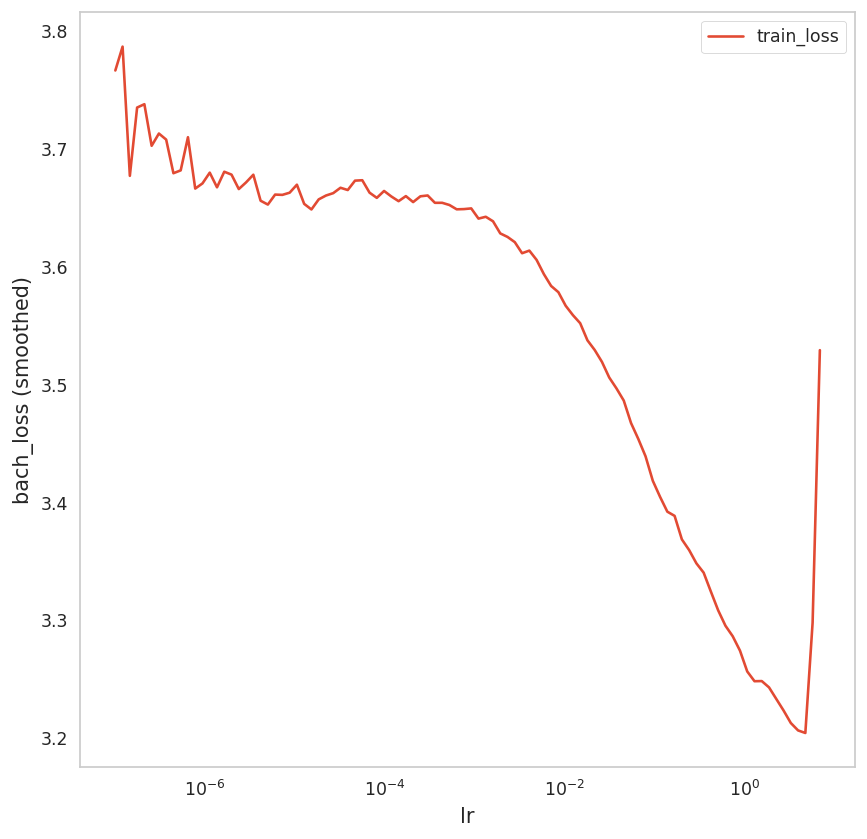

In [536]:
batch_size = 64
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()


In [537]:
lrfinder.get_best_lr()

0.4750810162102829

In [538]:
model.optimizer.set_lr(0.001)

In [539]:
epochs = 128
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [540]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose)

0:	[0s / 0s],		train_loss: 3.6423
1:	[0s / 0s],		train_loss: 3.5058
2:	[0s / 0s],		train_loss: 3.5106
3:	[0s / 0s],		train_loss: 3.4825
4:	[0s / 0s],		train_loss: 3.4030
5:	[0s / 0s],		train_loss: 3.3968
6:	[0s / 0s],		train_loss: 3.3384
7:	[0s / 0s],		train_loss: 3.3172
8:	[0s / 0s],		train_loss: 3.2885
9:	[0s / 0s],		train_loss: 3.2616
CPU times: user 1.35 s, sys: 35 ms, total: 1.39 s
Wall time: 91.7 ms


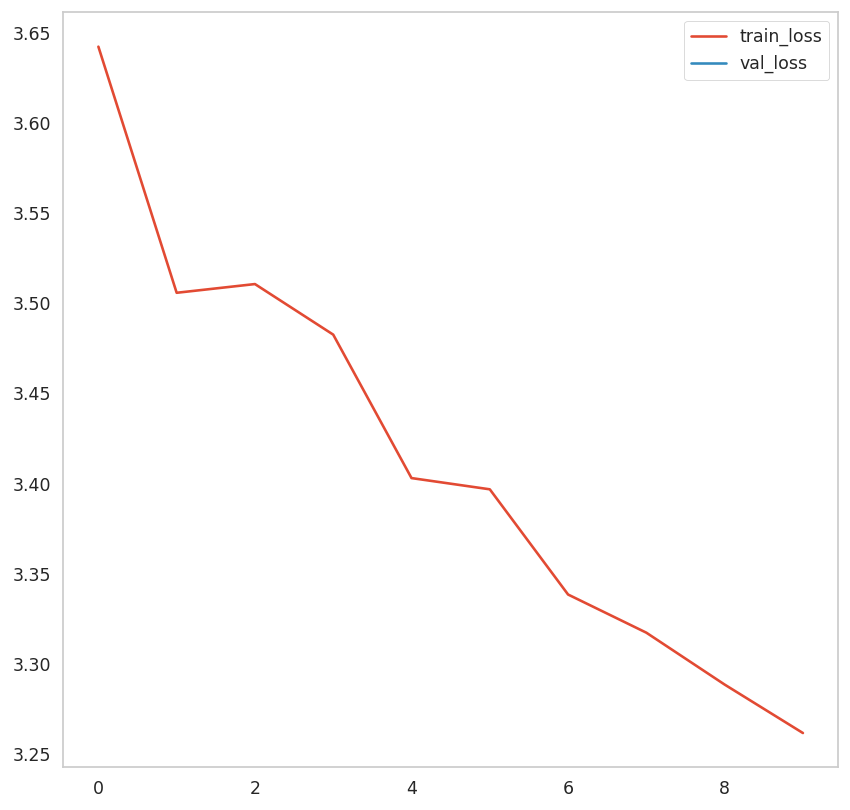

In [541]:
_ = log.plot()

In [542]:
_ = model.compute_baseline_hazards()

In [543]:
surv = model.predict_surv_df(x_test)

In [544]:
surv

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
duration,,,,,,,,,,,,,,,,,,,,,
4,0.992024,0.993631,0.995885,0.991347,0.993528,0.996009,0.996337,0.995279,0.995936,0.993252,...,0.994493,0.990398,0.995218,0.996277,0.996083,0.993001,0.990475,0.996019,0.994799,0.989936
7,0.984074,0.987272,0.991766,0.982727,0.987066,0.992015,0.992670,0.990558,0.991869,0.986517,...,0.988990,0.980842,0.990435,0.992549,0.992161,0.986016,0.980995,0.992035,0.989601,0.979924
8,0.976151,0.980925,0.987646,0.974144,0.980618,0.988019,0.989000,0.985838,0.987800,0.979798,...,0.983493,0.971336,0.985654,0.988819,0.988238,0.979050,0.971563,0.988049,0.984406,0.969970
9,0.968258,0.974590,0.983525,0.965597,0.974183,0.984021,0.985327,0.981119,0.983730,0.973094,...,0.978002,0.961880,0.980874,0.985086,0.984313,0.972101,0.962180,0.984060,0.979215,0.960072
15,0.952557,0.961959,0.975279,0.948616,0.961354,0.976020,0.977973,0.971687,0.975585,0.959735,...,0.967038,0.943118,0.971321,0.977612,0.976456,0.958260,0.943561,0.976079,0.968847,0.940448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,0.198602,0.275328,0.434981,0.173023,0.269625,0.446100,0.476759,0.384738,0.439542,0.254930,...,0.328021,0.142611,0.379953,0.470954,0.452784,0.242219,0.144859,0.447002,0.349052,0.129782
1351,0.198602,0.275328,0.434981,0.173023,0.269625,0.446100,0.476759,0.384738,0.439542,0.254930,...,0.328021,0.142611,0.379953,0.470954,0.452784,0.242219,0.144859,0.447002,0.349052,0.129782
1352,0.198602,0.275328,0.434981,0.173023,0.269625,0.446100,0.476759,0.384738,0.439542,0.254930,...,0.328021,0.142611,0.379953,0.470954,0.452784,0.242219,0.144859,0.447002,0.349052,0.129782


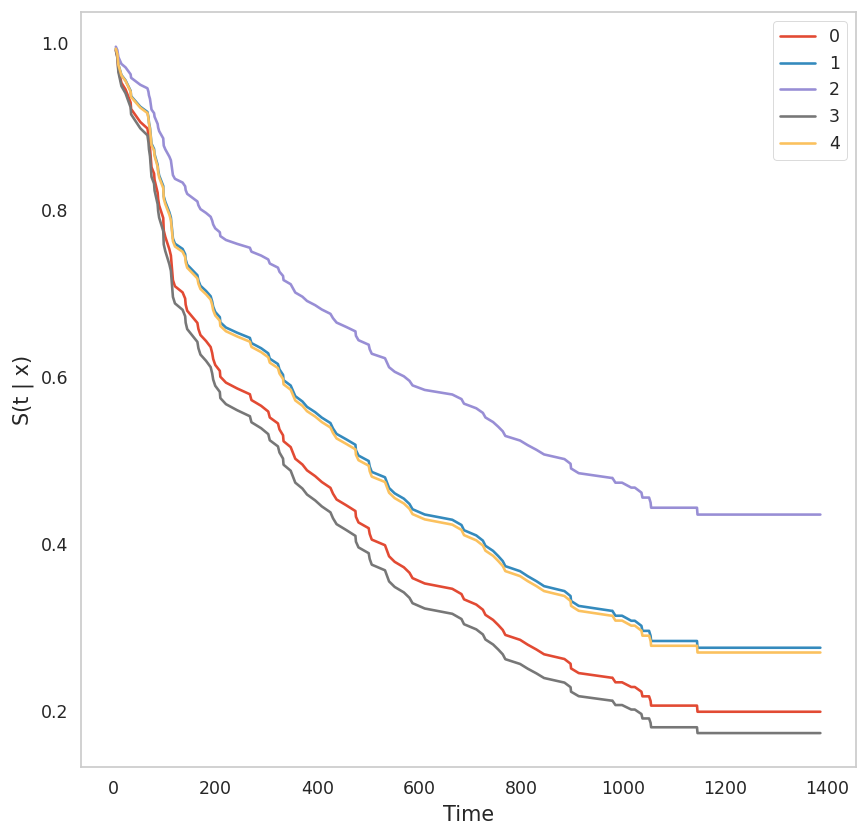

In [545]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


In [546]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [547]:
ev.concordance_td()

0.7400793650793651

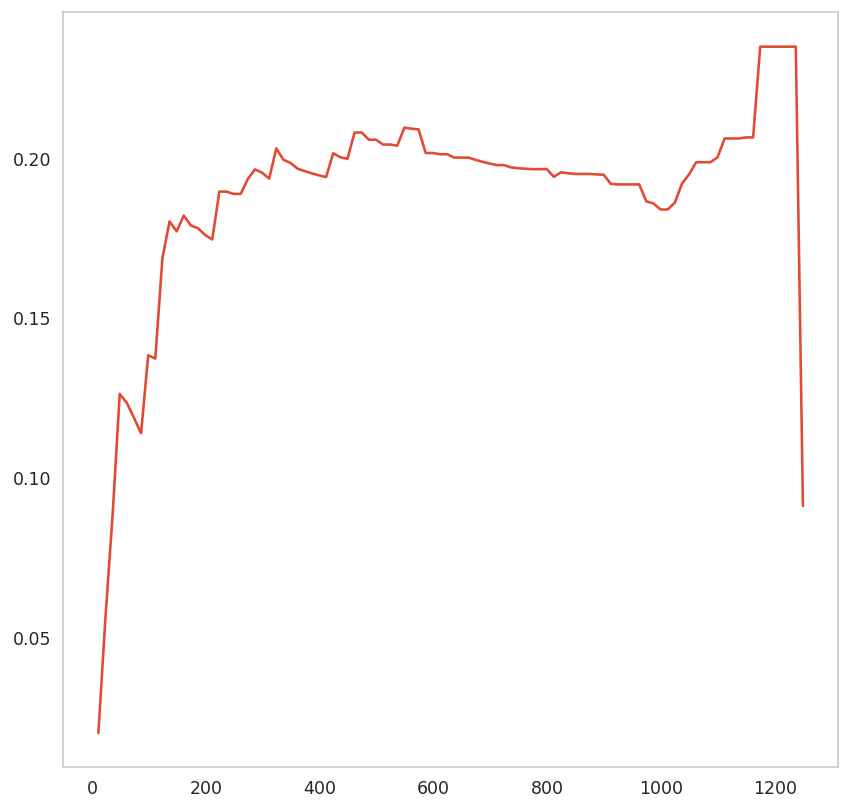

In [548]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [549]:
ev.integrated_brier_score(time_grid)

0.19023084583929975

In [550]:
ev.integrated_nbll(time_grid)

0.5638614168527833

In [565]:
model.save_net('pre-trainedDeepSurv-128.pt')

In [566]:
model.save_model_weights('pre-trainedDeepSurv-128-weights.pt')